In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import torch
import time
import sys
import resource
from torch.utils.data import DataLoader

from data_classes import *
from read_input import *
from read_trainset import *
from network import *
from prepare_batches import *
from traininit import *
from data_set import *
from data_loader import *
from optimization_step import *
from output_nn import *
from py_aeio import *

/nethome/farri002/miniconda3/envs/tyxe/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = "cpu"

In [5]:
tin_file = "/nethome/farri002/mlp-pt-au-o-h/ml-construction/PdO/desc-20-8/NN-20-20/train.in"
tin = read_train_in(tin_file)
torch.manual_seed(tin.pytorch_seed)
np.random.seed(tin.numpy_seed)
if tin.verbose: io_input_reading(tin)
tin.train_file = '/nethome/farri002/mlp-pt-au-o-h/ml-construction/PdO/desc-20-8/data.train.ascii'
tin.train_forces_file = '/nethome/farri002/mlp-pt-au-o-h/ml-construction/PdO/desc-20-8/data.train.forces'

In [6]:
if tin.verbose : io_trainingset_information()
list_structures_energy, list_structures_forces, list_removed, max_nnb, tin = read_list_structures(tin)

In [7]:
N_removed = len(list_removed)
N_struc_E = len(list_structures_energy)
N_struc_F = len(list_structures_forces)
if tin.verbose : io_trainingset_information_done(tin, tin.trainset_params, N_struc_E, N_struc_F, N_removed)

if tin.verbose : io_prepare_batches()

N_batch_train, N_batch_valid = select_batch_size(tin, list_structures_energy, list_structures_forces)

# Join datasets with forces and only energies in a single torch dataset AND prepare batches
train_forces_data, valid_forces_data, train_energy_data, valid_energy_data = select_batches(tin, tin.trainset_params, device, list_structures_energy, list_structures_forces,
                                                                                        max_nnb, N_batch_train, N_batch_valid)

del list_structures_energy
del list_structures_forces

if tin.verbose : io_prepare_batches_done(tin, train_energy_data, train_forces_data)

In [8]:
grouped_train_data = GroupedDataset(train_energy_data, train_forces_data,
									 memory_mode=tin.memory_mode, device=device, dataname="train")
grouped_valid_data = GroupedDataset(valid_energy_data, valid_forces_data,
									 memory_mode=tin.memory_mode, device=device, dataname="valid")

In [9]:
del train_forces_data
del valid_forces_data
del train_energy_data
del valid_energy_data

In [10]:
# 4. Initialize dataloader
grouped_train_loader = DataLoader(grouped_train_data, batch_size=1, shuffle=False,
                                  collate_fn=custom_collate, num_workers=0)
grouped_valid_loader = DataLoader(grouped_valid_data, batch_size=1, shuffle=False,
                                  collate_fn=custom_collate, num_workers=0)

In [11]:
grouped_train_data

In [12]:
for data_batch in grouped_train_loader:
    grp_descrp, grp_energy, logic_reduce = data_batch[0][10], data_batch[0][11], data_batch[0][12]


grp_descrp[0] = grp_descrp[0].float()
grp_descrp[1] = grp_descrp[1].float()

logic_reduce[0] = logic_reduce[0].float()
logic_reduce[1] = logic_reduce[1].float()

In [40]:
from bayesian_network import BayesianNetAtoms
from pyro.nn.module import to_pyro_module_
from pyro.nn import PyroSample
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDiagonalNormal
import pyro

model = NetAtom(tin.networks_param["input_size"], tin.networks_param["hidden_size"],
			    tin.sys_species, tin.networks_param["activations"], tin.alpha, device)

to_pyro_module_(model)

weight_labels = [f'Pt_h{i}_weight' for i in range(3)] + [f'O_h{i}_weight' for i in range(3)]
bias_labels = [f'Pt_h{i}_bias' for i in range(3)] + [f'O_h{i}_bias' for i in range(3)]

i = 0
for m in model.modules():
    for name, value in list(m.named_parameters(recurse=False)):
        if name == 'weight':
            setattr(m, name, PyroSample(prior=dist.Normal(0, 1)
                                              .expand(value.shape)
                                              .to_event(value.dim())))
        if name == 'bias':
            setattr(m, name, PyroSample(prior=dist.Normal(0, 10)
                                              .expand(value.shape)
                                              .to_event(value.dim())))
            i += 1

def bayesian_net(grp_descrp, logic_reduce, grp_energy=None):
    
    local_plates = {i : pyro.plate(f'iest_{i}', len(grp_descrp[i])) for i in range(len(model.species))}
    local_sigma = {iesp : pyro.sample(f'noise_{iesp}', dist.Uniform(0,10)) for iesp in range(len(model.species))}
    sigma_fin = pyro.sample('noise', dist.Uniform(0,10))

    partial_E_ann = [0 for i in range(len(model.species))]

    for iesp, local_plate in local_plates.items():
        partial_E_ann[iesp] = model.functions[iesp](grp_descrp[iesp])

    list_E_ann = torch.zeros( (len(logic_reduce[0])), device=model.device ).double()
    for iesp in range(len(model.species)):
        list_E_ann = list_E_ann + torch.einsum( "ij,ki->k", partial_E_ann[iesp], logic_reduce[iesp])

    with pyro.plate('data', len(logic_reduce[0])): # number of configurations
        a = pyro.sample('obs', dist.Normal(list_E_ann, sigma_fin), obs=grp_energy)
    return list_E_ann
      
def bnn(grp_descrp, logic_reduce, grp_energy=None):    
    partial_E_ann = [0 for i in range(len(model.species))]
        
    for iesp in range(len(model.species)):
        partial_E_ann[iesp] = model.functions[iesp](grp_descrp[iesp])

    # Gather back all atoms corresponding to the same strucuture from partial_E_ann
    
    sigma = pyro.sample('noise', dist.Uniform(0,10))
    with pyro.plate('data', len(logic_reduce[0])):

        list_E_ann = torch.zeros( (len(logic_reduce[0])), device=model.device ).double()
        for iesp in range(len(model.species)):
            list_E_ann = list_E_ann + torch.einsum( "ij,ki->k", partial_E_ann[iesp], logic_reduce[iesp] )
        pyro.sample('obs', dist.Normal(list_E_ann, sigma), obs=grp_energy)
    return list_E_ann

# model = BayesianNetAtoms(net)       
guide = AutoDiagonalNormal(bayesian_net)

In [41]:
from pyro.infer import SVI, Trace_ELBO

pyro.clear_param_store()
adam = pyro.optim.Adam({"lr": 0.05})
svi = SVI(bayesian_net, guide, adam, loss=Trace_ELBO())
for x in range(10000):
    if x % 1000:
        print(svi.step(grp_descrp, logic_reduce, grp_energy))

174861.17959222736
47199.76044634677
13470.744267516682
13189.450871814333
15027.457202837706
12462.759325440518
16958.796687277973
27710.187923541354
9536.768686897773
11908.727708397591
12422.219521783569
9122.748059670144
9514.384077674365
10958.024965453671
10108.269598523311
9011.855216756998
8820.418811351754
8564.052398100568
11181.470792808701
9394.344557977503
8603.916061091079
11667.712825363931
12084.999415587572
8867.081632513213
9654.766074750012
9819.543837779918
8202.797067740688
12300.00942776704
9907.813549603865
18711.006935172805
8608.096880079047
15667.962467539837
8023.077880814793
7884.890776802439
9837.309002312259
7875.224591280096
18242.2220187849
8588.337303013435
9007.912745815878
7978.306690931508
7632.514239810566
9625.619073077996
10138.626404495506
7719.144017898501
10797.394890242498
8874.991869505528
9108.706824015062
8188.131509769252
7728.96295397825
13315.679145801103
10244.291918196464
7224.462030823134
7319.529872398959
10693.47772614596
7238.74990

In [42]:
from pyro.infer import Predictive

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0).numpy(),
            "std": torch.std(v, 0).numpy(),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0].numpy(),
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0].numpy(),
        }
    return site_stats


predictive = Predictive(bnn, guide=guide, num_samples=800,
                        return_sites=("weight", "obs", "_RETURN"))

samples = predictive(grp_descrp, logic_reduce)
mu = summary(samples)

(-38.0, -31.5)

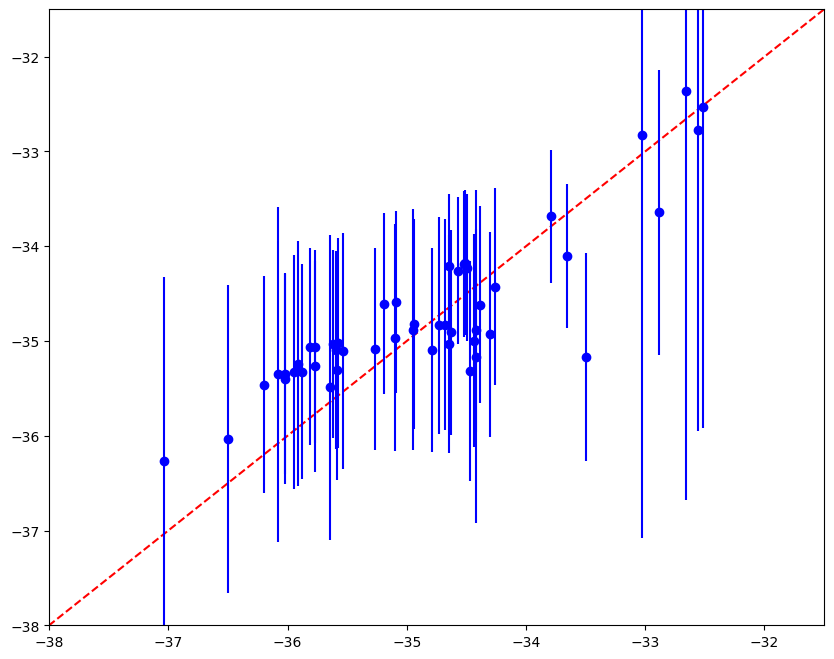

In [47]:
import numpy as np
import matplotlib.pyplot as plt
i = 0
fig, ax = plt.subplots(1,1, figsize=(10,8))
x = np.linspace(-100,100,1000)
ax.plot(x,x, '--r')
for y_pred, y_std, y in zip(mu['_RETURN']['mean'], mu['_RETURN']['std'], grp_energy):
    #plt.scatter(y, y_pred, color='b')
    ax.errorbar(y, y_pred,fmt='o', c='blue', yerr=y_std)
    #ax[1].errorbar(y_pred, y,fmt='o', c='red', xerr=y_std)
    i += 1

    if i == 50:
        break

ax.set_ylim(-38,-31.5)
ax.set_xlim(-38,-31.5)


#ax[1].set_ylim(-39,-31)
#ax[1].set_xlim(-39,-31)

In [46]:
for i in zip(mu['_RETURN']['mean'], mu['_RETURN']['std'], grp_energy):
    print(i)

(-34.88159859556705, 1.2708019300372377, tensor(-34.9457, dtype=torch.float64))
(-34.96476843653247, 1.1978269538817043, tensor(-35.0953, dtype=torch.float64))
(-34.82889162812382, 1.1120830906218324, tensor(-34.6794, dtype=torch.float64))
(-35.303721883110704, 1.167475907524657, tensor(-35.5816, dtype=torch.float64))
(-35.10936744280159, 1.245250246367567, tensor(-35.5390, dtype=torch.float64))
(-34.103054333776235, 0.7548266456176728, tensor(-33.6583, dtype=torch.float64))
(-32.35915754990652, 4.314775774207114, tensor(-32.6542, dtype=torch.float64))
(-36.262357175573705, 1.942229398290329, tensor(-37.0372, dtype=torch.float64))
(-35.16720832880586, 1.0971599175087712, tensor(-33.4976, dtype=torch.float64))
(-34.608394868150356, 0.9549492167662764, tensor(-35.1922, dtype=torch.float64))
(-36.03591190023348, 1.6223854225275771, tensor(-36.4988, dtype=torch.float64))
(-33.64196128210053, 1.5055929070277516, tensor(-32.8841, dtype=torch.float64))
(-34.887900763936344, 1.0733152585956678

In [ ]:
model = BayesianNetAtoms(net.functions, net.species, net.device)

pyro.render_model(model, model_args=([torch.ones(108, 52),torch.ones(108, 52)], [torch.ones([4, 108]),torch.ones([4, 108])], torch.ones(4,)))#,grp_energy))

NameError: name 'net' is not defined

In [ ]:
# 4. Initialize dataloader
grouped_train_loader = DataLoader(grouped_train_data, batch_size=1, shuffle=False,
                                  collate_fn=custom_collate, num_workers=0)
grouped_valid_loader = DataLoader(grouped_valid_data, batch_size=1, shuffle=False,
                                  collate_fn=custom_collate, num_workers=0)

In [ ]:
for data_batch in grouped_train_loader:
    grp_descrp, grp_energy, logic_reduce = data_batch[0][10], data_batch[0][11], data_batch[0][12]

In [ ]:
grp_energy

tensor([-27.0000, -17.8317,   2.4570,   3.1589], dtype=torch.float64)

In [ ]:
logic_reduce[0].shape

torch.Size([4, 108])

In [ ]:
grp_descrp[0] = grp_descrp[0].float()
logic_reduce[0] =logic_reduce[0].float()

In [ ]:
model.forward(grp_descrp, logic_reduce, grp_energy)

tensor([ 302.2620, -196.0373,  209.5111,  309.6779], grad_fn=<AddBackward0>)

In [ ]:
model.svi.step(grp_descrp, logic_reduce,grp_energy)

NotImplementedError: 
Trace Shapes:
 Param Sites:
Sample Sites:

In [ ]:
for m in model.modules():
    m.model(data_batch[0][10][0], data_batch[0][10][0], data_batch[0][12][0])

NotImplementedError: 

In [ ]:
model.model(data_batch[0][10], data_batch[0][12])

RuntimeError: expected scalar type Float but found Double

In [ ]:
for data_batch in grouped_train_loader:
    grp_descrp, grp_energy, logic_reduce, grp_N_atom = data_batch[0][10], data_batch[0][11], data_batch[0][12], data_batch[0][14]


In [ ]:
grp_N_atom

tensor([27., 27., 27., 27.], dtype=torch.float64)

In [ ]:
grp_descrp[0].shape

torch.Size([108, 52])

In [ ]:
for data_batch in grouped_train_loader:
    model.step(data_batch[0][10], data_batch[0][12])

RuntimeError: expected scalar type Float but found Double
                              Trace Shapes:        
                               Param Sites:        
                              Sample Sites:        
model.functions.0.Linear_Sp1_F1.weight dist | 15 52
                                      value | 15 52
  model.functions.0.Linear_Sp1_F1.bias dist | 15   
                                      value | 15   
Trace Shapes:
 Param Sites:
Sample Sites:

In [ ]:
data_batch[0][10]

[tensor([[-0.0789,  0.7212, -1.5706,  ...,  1.3901,  1.2308,  0.2393],
         [-1.0732,  0.9951,  0.0450,  ...,  0.4152, -0.1812,  0.9815],
         [ 0.3986, -0.4489,  0.1622,  ..., -0.2772, -0.7212,  0.4384],
         ...,
         [-0.6189, -2.1412,  1.5223,  ..., -1.7583, -1.2087, -2.4926],
         [ 1.6111,  0.4451, -0.4222,  ...,  0.3068,  0.3127, -0.5332],
         [-0.1283, -0.6618, -0.9102,  ...,  0.5214, -0.0743,  0.6787]],
        dtype=torch.float64),
 tensor([], size=(0, 52), dtype=torch.float64)]